In [13]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from prettytable import PrettyTable

stock_returns = pd.read_csv('South Africa Company Data.csv')
market_index_and_risk_free = pd.read_csv('South Africa Market Return and Risk Free.csv')

stock_returns['Date'] = pd.to_datetime(stock_returns['Date'])
market_index_and_risk_free['Date'] = pd.to_datetime(market_index_and_risk_free['Date'])

stock_returns.sort_values(by=['Ticker', 'Date'], inplace=True)

stock_returns['YoY_Total_Assets'] = stock_returns.groupby('Ticker')['Total Assets'].diff(12)

start_date = '2019-01-31'
end_date = '2023-12-31'
stock_returns = stock_returns[(stock_returns['Date'] >= start_date) & (stock_returns['Date'] <= end_date)]
market_index_and_risk_free = market_index_and_risk_free[(market_index_and_risk_free['Date'] >= start_date) & (market_index_and_risk_free['Date'] <= end_date)]

stock_returns['Book_to_Market'] = stock_returns['Tangible Book Value'] / stock_returns['Market Capitalisation']

stock_returns = stock_returns[(stock_returns['Market Capitalisation'] != 0) & (stock_returns['Return'] != 0) & (stock_returns['Book_to_Market'] != 0)
                             & (stock_returns['Operating Income'] != 0) & (stock_returns['YoY_Total_Assets'] != 0)]

market_index_and_risk_free['Rm'] = pd.to_numeric(market_index_and_risk_free['Rm'])
market_index_and_risk_free['Rf'] = pd.to_numeric(market_index_and_risk_free['Rf'])

merged_data = pd.merge(stock_returns, market_index_and_risk_free, on='Date', how='left')

merged_data['Mkt-RF'] = merged_data['Rm'] - merged_data['Rf']
merged_data['Excess_Return'] = merged_data['Return'] - merged_data['Rf']


/var/folders/9d/s8hs65kn1hqf691ny_03xr0w0000gn/T/ipykernel_20299/3883636793.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_returns['Date'] = pd.to_datetime(stock_returns['Date'])
/var/folders/9d/s8hs65kn1hqf691ny_03xr0w0000gn/T/ipykernel_20299/3883636793.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  market_index_and_risk_free['Date'] = pd.to_datetime(market_index_and_risk_free['Date'])


In [18]:
import pandas as pd
from prettytable import PrettyTable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_table = PrettyTable()
vif_table.field_names = ["Feature", "VIF"]

for i, row in vif_data.iterrows():
    vif_table.add_row([row['feature'], row['VIF']])

print("Variance Inflation Factor (VIF) Results for South Africa:")
print(vif_table)

if (vif_data['VIF'] > 10).any():
    print("Warning: High multicollinearity detected in the predictor variables.")
else:
    print("No evidence of multicollinearity issues among the predictor variables.")


Variance Inflation Factor (VIF) Results for South Africa:
+---------+--------------------+
| Feature |        VIF         |
+---------+--------------------+
|  const  | 2.0761643791234325 |
|  Mkt-RF | 1.2598060183842452 |
|   SMB   | 1.0379157619417598 |
|   HML   | 1.7599199730653858 |
|   RMW   |  1.38942896385964  |
|   CMA   | 1.5254852361018618 |
+---------+--------------------+
No evidence of multicollinearity issues among the predictor variables.


In [19]:
def calculate_factors(df):
    median_mc = df['Market Capitalisation'].median()
    df['Operating_Profitability'] = df['Operating Income'] / df['Total Assets']
    median_op_profit = df['Operating_Profitability'].median()
    median_inv = df['YoY_Total_Assets'].median()


    small = df[df['Market Capitalisation'] < median_mc]
    big = df[df['Market Capitalisation'] >= median_mc]
    robust = df[df['Operating_Profitability'] >= median_op_profit]
    weak = df[df['Operating_Profitability'] < median_op_profit]
    conservative = df[df['YoY_Total_Assets'] <= median_inv]
    aggressive = df[df['YoY_Total_Assets'] > median_inv]


    tertiles_bm = df['Book_to_Market'].quantile([0.333, 0.666])
    SL = small[small['Book_to_Market'] <= tertiles_bm.loc[0.333]]
    SM = small[(small['Book_to_Market'] > tertiles_bm.loc[0.333]) & (small['Book_to_Market'] <= tertiles_bm.loc[0.666])]
    SH = small[small['Book_to_Market'] > tertiles_bm.loc[0.666]]
    
    BL = big[big['Book_to_Market'] <= tertiles_bm.loc[0.333]]
    BM = big[(big['Book_to_Market'] > tertiles_bm.loc[0.333]) & (big['Book_to_Market'] <= tertiles_bm.loc[0.666])]
    BH = big[big['Book_to_Market'] > tertiles_bm.loc[0.666]]

    portfolio_returns = {}
    for portfolio in ('SL', 'SM', 'SH', 'BL', 'BM', 'BH'):
        portfolio_df = locals()[portfolio]
        if not portfolio_df.empty:
            portfolio_returns[portfolio] = portfolio_df['Excess_Return'].mean()
        else:
            portfolio_returns[portfolio] = 0 

    smb = (portfolio_returns.get('SL', 0) + portfolio_returns.get('SM', 0) + portfolio_returns.get('SH', 0)) / 3 - \
          (portfolio_returns.get('BL', 0) + portfolio_returns.get('BM', 0) + portfolio_returns.get('BH', 0)) / 3

    hml = (portfolio_returns.get('SH', 0) + portfolio_returns.get('BH', 0)) / 2 - \
          (portfolio_returns.get('SL', 0) + portfolio_returns.get('BL', 0)) / 2

    SR = robust[robust['Market Capitalisation'] < median_mc]['Excess_Return'].mean()
    SW = weak[weak['Market Capitalisation'] < median_mc]['Excess_Return'].mean()
    BR = robust[robust['Market Capitalisation'] >= median_mc]['Excess_Return'].mean()
    BW = weak[weak['Market Capitalisation'] >= median_mc]['Excess_Return'].mean()
    
    SC = conservative[conservative['Market Capitalisation'] < median_mc]['Excess_Return'].mean()
    SA = aggressive[aggressive['Market Capitalisation'] < median_mc]['Excess_Return'].mean()
    BC = conservative[conservative['Market Capitalisation'] >= median_mc]['Excess_Return'].mean()
    BA = aggressive[aggressive['Market Capitalisation'] >= median_mc]['Excess_Return'].mean()

    rmw = (SR - SW) / 2 + (BR - BW) / 2
    cma = (SC - SA) / 2 + (BC - BA) / 2

    return pd.Series([smb, hml, rmw, cma], index=['SMB', 'HML', 'RMW', 'CMA'])

factors = merged_data.groupby('Date').apply(calculate_factors)

portfolio_returns = merged_data.groupby('Date').agg({'Excess_Return': 'mean', 'Mkt-RF': 'first'}).reset_index()
portfolio_returns = portfolio_returns.rename(columns={'Excess_Return': 'Portfolio_Excess_Return'})

final_data = pd.merge(portfolio_returns, factors, on='Date')

X = sm.add_constant(final_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
y = final_data['Portfolio_Excess_Return']


model = sm.OLS(y, X).fit()

header_text = "Fama-French Five-Factor Model for South Africa"

console_width = 80

centered_header = header_text.center(console_width)

print(centered_header)

print(model.summary())


                 Fama-French Five-Factor Model for South Africa                 
                               OLS Regression Results                              
Dep. Variable:     Portfolio_Excess_Return   R-squared:                       0.947
Model:                                 OLS   Adj. R-squared:                  0.943
Method:                      Least Squares   F-statistic:                     194.5
Date:                     Mon, 22 Apr 2024   Prob (F-statistic):           3.06e-33
Time:                             16:06:13   Log-Likelihood:                 170.64
No. Observations:                       60   AIC:                            -329.3
Df Residuals:                           54   BIC:                            -316.7
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


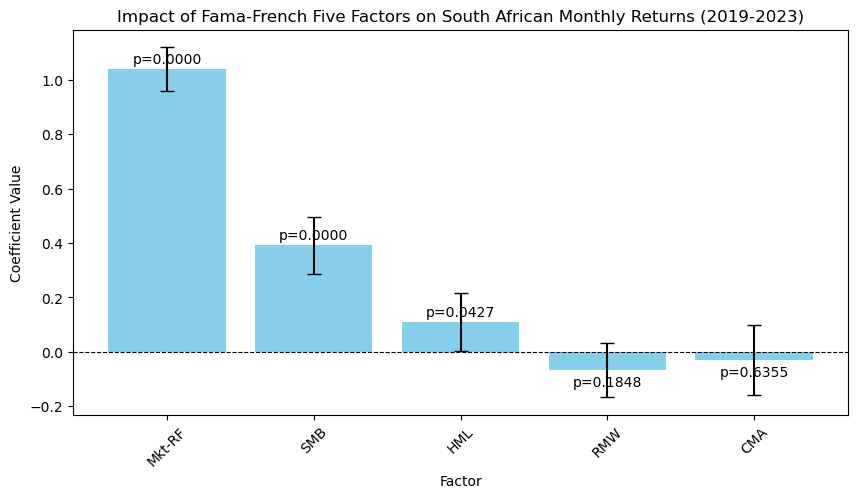

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

factors = model.params.index[1:]  
coefficients = model.params.values[1:]
conf_int = model.conf_int().iloc[1:]  
errors = (conf_int[1] - conf_int[0]) / 2  

ols_data = pd.DataFrame({
    "Factor": factors,
    "Coefficient": coefficients,
    "Error": errors,
    "P-Value": model.pvalues[1:]  
})


fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(ols_data['Factor'], ols_data['Coefficient'], yerr=ols_data['Error'], capsize=5, color='skyblue', label='Coefficient')
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")  

for i, (pval, coef) in enumerate(zip(ols_data['P-Value'], ols_data['Coefficient'])):
    ax.text(i, coef + (0.01 if coef >= 0 else -0.02), f'p={pval:.4f}', color='black', ha='center', va='bottom' if coef >= 0 else 'top')

ax.set_title("Impact of Fama-French Five Factors on South African Monthly Returns (2019-2023)")
ax.set_xlabel("Factor")
ax.set_ylabel("Coefficient Value")
plt.xticks(rotation=45) 

plt.show()